# Assignment #2 (demo)

## Analyzing cardiovascular disease data

```{figure} /_static/img/ods_stickers.jpg
```

**<center>[mlcourse.ai](https://mlcourse.ai) – Open Machine Learning Course** </center><br>
Authors: [Ilya Baryshnikov](https://www.linkedin.com/in/baryshnikov-ilya/), [Maxim Uvarov](https://www.linkedin.com/in/maxis42/), and [Yury Kashnitsky](https://www.linkedin.com/in/festline/). Translated and edited by [Inga Kaydanova](https://www.linkedin.com/in/inga-kaidanova-a92398b1/), [Egor Polusmak](https://www.linkedin.com/in/egor-polusmak/), [Anastasia Manokhina](https://www.linkedin.com/in/anastasiamanokhina/), and [Yuanyuan Pao](https://www.linkedin.com/in/yuanyuanpao/). All content is distributed under the [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/) license.


**Same assignment as a [Kaggle Kernel](https://www.kaggle.com/kashnitsky/a2-demo-analyzing-cardiovascular-data) + [solution](https://www.kaggle.com/kashnitsky/a2-demo-analyzing-cardiovascular-data-solution).**

In this assignment, you will answer questions about a dataset on cardiovascular disease. You do not need to download the data: it is already in the repository. There are some Tasks that will require you to write code. Complete them and then answer the questions in the [form](https://docs.google.com/forms/d/13cE_tSIb6hsScQvvWUJeu1MEHE5L6vnxQUbDYpXsf24).

### Problem

Predict the presence or absence of cardiovascular disease (CVD) using the patient examination results.

### Data description

There are 3 types of input features:

- *Objective*: factual information;
- *Examination*: results of medical examination;
- *Subjective*: information given by the patient.

| Feature | Variable Type | Variable      | Value Type |
|---------|--------------|---------------|------------|
| Age | Objective Feature | age | int (days) |
| Height | Objective Feature | height | int (cm) |
| Weight | Objective Feature | weight | float (kg) |
| Gender | Objective Feature | gender | categorical code |
| Systolic blood pressure | Examination Feature | ap_hi | int |
| Diastolic blood pressure | Examination Feature | ap_lo | int |
| Cholesterol | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |
| Glucose | Examination Feature | gluc | 1: normal, 2: above normal, 3: well above normal |
| Smoking | Subjective Feature | smoke | binary |
| Alcohol intake | Subjective Feature | alco | binary |
| Physical activity | Subjective Feature | active | binary |
| Presence or absence of cardiovascular disease | Target Variable | cardio | binary |

All of the dataset values were collected at the moment of medical examination.

Let's get to know our data by performing a preliminary data analysis.

##  Part 1. Preliminary data analysis

First, we will initialize the environment:

In [1]:
# Import all required modules
# Disable warnings
import warnings

import numpy as np
import pandas as pd

warnings.filterwarnings("ignore")

# Import plotting modules and set up
import seaborn as sns

sns.set()
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

You will use the `seaborn` library for visual analysis, so let's set that up too:

In [2]:
# Tune the visual settings for figures in `seaborn`
sns.set_context(
    "notebook", font_scale=1.5, rc={"figure.figsize": (11, 8), "axes.titlesize": 18}
)

from matplotlib import rcParams

rcParams["figure.figsize"] = 11, 8

To make it simple, we will work only with the training part of the dataset:

In [3]:
# for Jupyter-book, we copy data from GitHub, locally, to save Internet traffic,
# you can specify the data/ folder from the root of your cloned
# https://github.com/Yorko/mlcourse.ai repo, to save Internet traffic
DATA_PATH = "https://raw.githubusercontent.com/Yorko/mlcourse.ai/master/data/"

In [4]:
df = pd.read_csv(DATA_PATH + "mlbootcamp5_train.csv", sep=";")
print("Dataset size: ", df.shape)
df.head()

Dataset size:  (70000, 13)


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


It would be instructive to peek into the values of our variables.

Let's convert the data into *long* format and depict the value counts of the categorical features using [`catplot()`](https://seaborn.pydata.org/generated/seaborn.catplot.html).

In [19]:
df_uniques = pd.melt(
    frame=df,
    value_vars=["gender", "cholesterol", "gluc", "smoke", "alco", "active", "cardio"],
)
df_uniques

,variable,value
0,gender,2
1,gender,1
2,gender,1
3,gender,2
4,gender,1
...,...,...
489995,cardio,0
489996,cardio,1
489997,cardio,1
489998,cardio,1


In [20]:
df_uniques = (
    pd.DataFrame(df_uniques.groupby(["variable", "value"])["value"].count())
    .sort_index(level=[0, 1])
    .rename(columns={"value": "count"})
    .reset_index()
)

In [21]:
df_uniques

,variable,value,count
0,active,0,13739
1,active,1,56261
2,alco,0,66236
3,alco,1,3764
4,cardio,0,35021
5,cardio,1,34979
6,cholesterol,1,52385
7,cholesterol,2,9549
8,cholesterol,3,8066
9,gender,1,45530


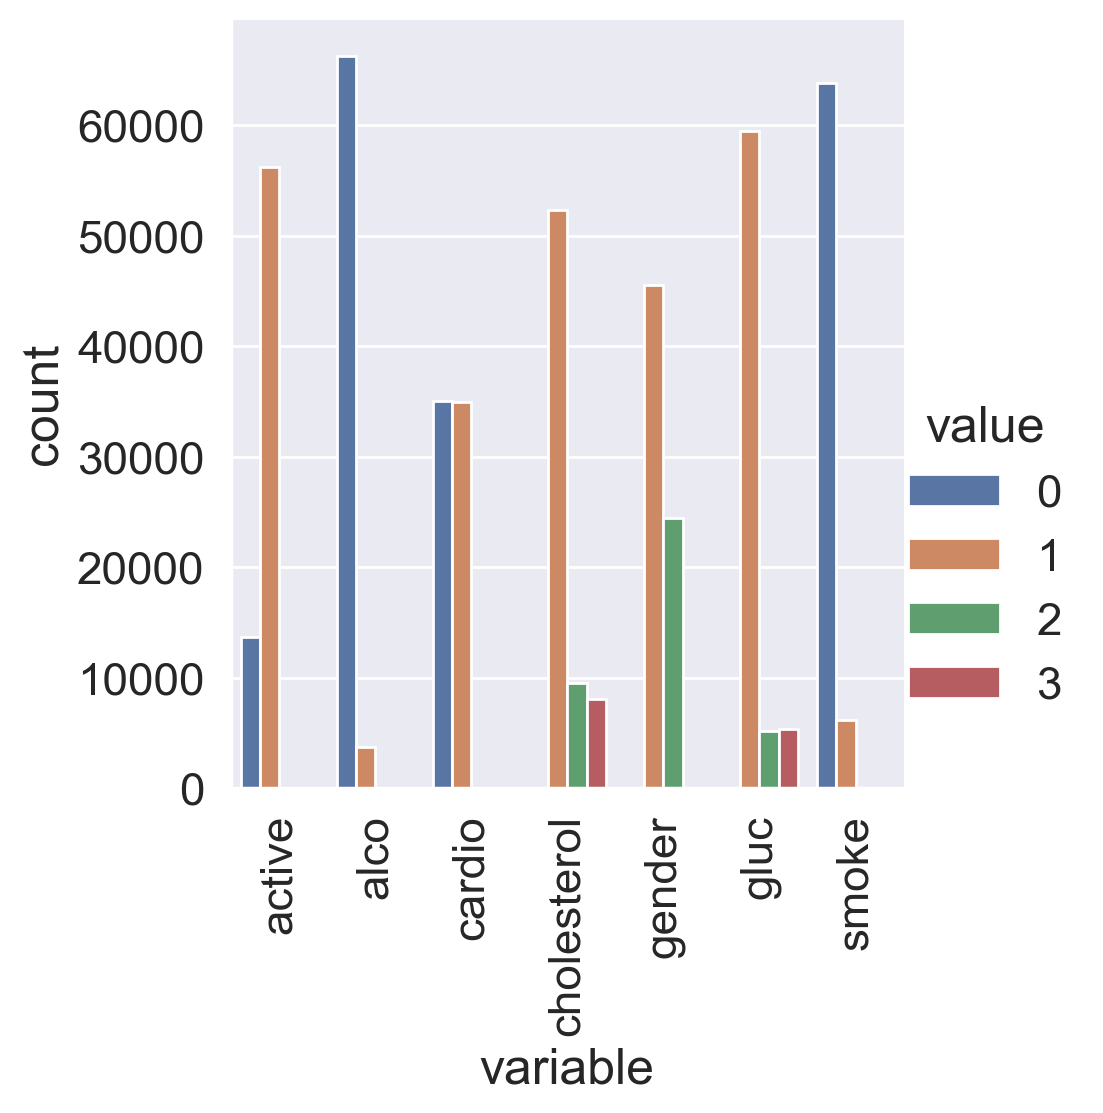

In [22]:
sns.catplot(
    x="variable", y="count", hue="value", data=df_uniques, kind="bar"
)
plt.xticks(rotation='vertical');

We can see that the target classes are balanced. That's great!

Let's split the dataset by target values. Can you already spot the most significant feature by just looking at the plot?

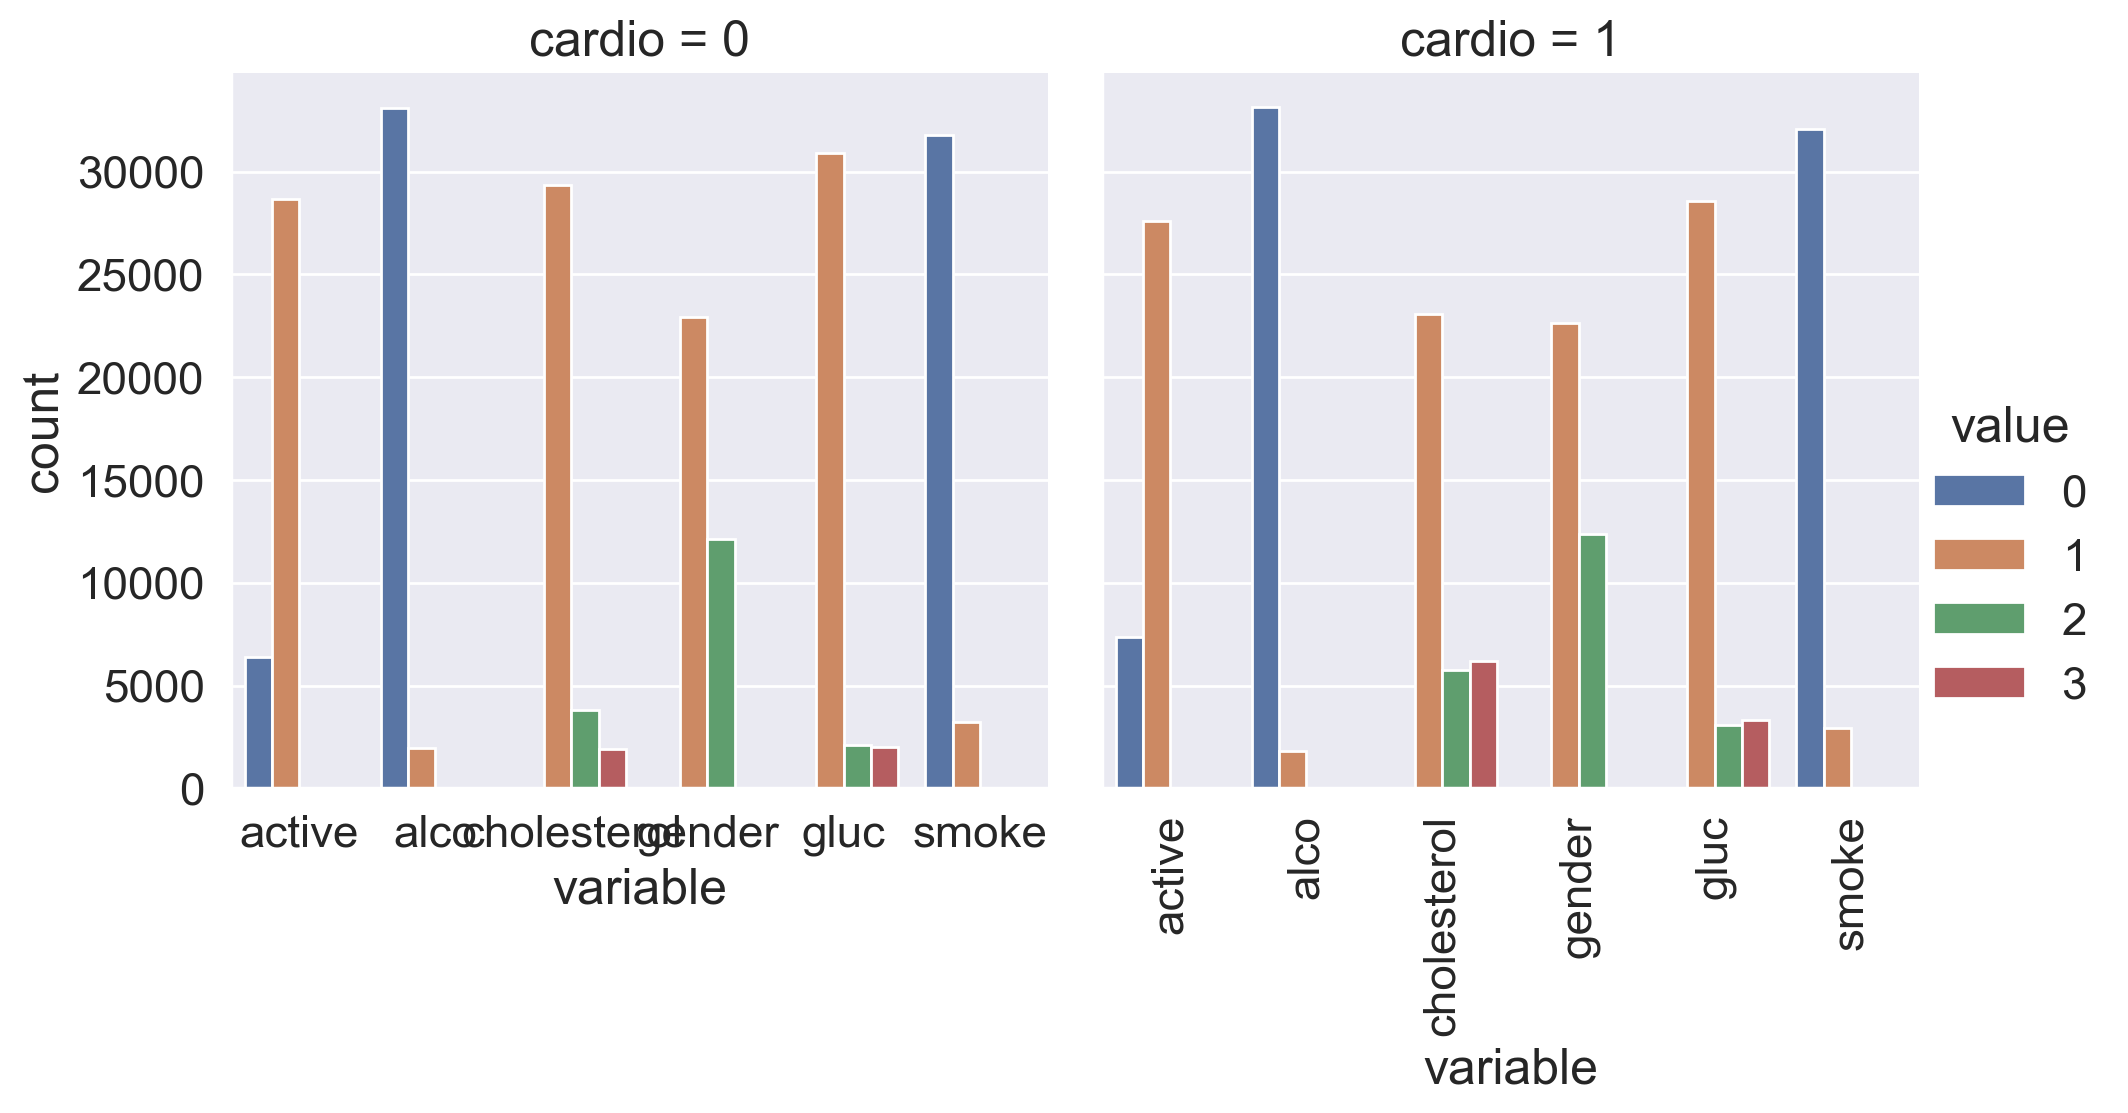

In [23]:
df_uniques = pd.melt(
    frame=df,
    value_vars=["gender", "cholesterol", "gluc", "smoke", "alco", "active"],
    id_vars=["cardio"],
)
df_uniques = (
    pd.DataFrame(df_uniques.groupby(["variable", "value", "cardio"])["value"].count())
    .sort_index(level=[0, 1])
    .rename(columns={"value": "count"})
    .reset_index()
)

sns.catplot(
    x="variable",
    y="count",
    hue="value",
    col="cardio",
    data=df_uniques,
    kind="bar",
)
plt.xticks(rotation='vertical');

You can see that the distribution of cholesterol and glucose levels great differs by the value of the target variable. Is this a coincidence?

Now, let's calculate some statistics for the feature unique values:

In [24]:
for c in df.columns:
    n = df[c].nunique()
    print(c)
    if n <= 3:
        print(n, sorted(df[c].value_counts().to_dict().items()))
    else:
        print(n)
    print(10 * "-")

id
70000
----------
age
8076
----------
gender
2 [(1, 45530), (2, 24470)]
----------
height
109
----------
weight
287
----------
ap_hi
153
----------
ap_lo
157
----------
cholesterol
3 [(1, 52385), (2, 9549), (3, 8066)]
----------
gluc
3 [(1, 59479), (2, 5190), (3, 5331)]
----------
smoke
2 [(0, 63831), (1, 6169)]
----------
alco
2 [(0, 66236), (1, 3764)]
----------
active
2 [(0, 13739), (1, 56261)]
----------
cardio
2 [(0, 35021), (1, 34979)]
----------


In the end, we have:
- 5 numerical features (excluding *id*);
- 7 categorical features;
- 70000 records in total.

## 1.1. Basic observations

**Question 1.1. (1 point). How many men and women are present in this dataset? Values of the `gender` feature were not given (whether "1" stands for women or for men) – figure this out by looking analyzing height, making the assumption that men are taller on average.**

1. 45530 women and 24470 men
2. 45530 men and 24470 women
3. 45470 women and 24530 men
4. 45470 men and 24530 women

In [27]:
df['gender'].value_counts()

1    45530
2    24470
Name: gender, dtype: int64

In [28]:
df.groupby(by='gender')['height'].mean()
# seems like 1 stands for female, 2 for male

gender
1    161.355612
2    169.947895
Name: height, dtype: float64

**Question 1.2. (1 point). Who more often report consuming alcohol – men or women?**
1. women
2. men

In [29]:
df.groupby(by='gender')['alco'].sum()
# men consume alcohol more often

gender
1    1161
2    2603
Name: alco, dtype: int64

**Question 1.3. (1 point). What's the rounded difference between the percentages of smokers among men and women?**
1. 4
2. 16
3. 20
4. 24

In [33]:
df.groupby(by=['gender'])['smoke'].value_counts(normalize=True)
# ~20%

gender  smoke
1       0        0.982144
        1        0.017856
2       0        0.781120
        1        0.218880
Name: smoke, dtype: float64

**Question 1.4. (1 point). What's the rounded difference between median values of age (in months) for non-smokers and smokers? You'll need to figure out the units of feature `age` in this dataset.**

1. 5
2. 10
3. 15
4. 20

In [5]:
df['age'] = round(df['age'] / 365, 0)  # age in days

In [6]:
df

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50.0,2,168,62.0,110,80,1,1,0,0,1,0
1,1,55.0,1,156,85.0,140,90,3,1,0,0,1,1
2,2,52.0,1,165,64.0,130,70,3,1,0,0,0,1
3,3,48.0,2,169,82.0,150,100,1,1,0,0,1,1
4,4,48.0,1,156,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,99993,53.0,2,168,76.0,120,80,1,1,1,0,1,0
69996,99995,62.0,1,158,126.0,140,90,2,2,0,0,1,1
69997,99996,52.0,2,183,105.0,180,90,3,1,0,1,0,1
69998,99998,61.0,1,163,72.0,135,80,1,2,0,0,0,1


In [70]:
smokers_median = df.groupby(by='smoke')['age'].median()
smokers_median

smoke
0    54.0
1    52.0
Name: age, dtype: float64

In [71]:
int((smokers_median[0] - smokers_median[1]) * 12)

24

## 1.2. Risk maps
### Task:

On the website for the European Society of Cardiology, a [SCORE scale](https://www.escardio.org/Education/Practice-Tools/CVD-prevention-toolbox/SCORE-Risk-Charts) is provided. It is used for calculating the risk of death from a cardiovascular decease in the next 10 years. Here it is:

```{figure} /_static/img/SCORE_CVD_eng.png
```

Let's take a look at the upper-right rectangle, which shows a subset of smoking men aged from 60 to 65. (It's not obvious, but the values in the figure represent the upper bound).

We see the value 9 in the lower-left corner of the rectangle and 47 in the upper-right. This means that, for people in this gender-age group whose systolic pressure is less than 120, the risk of a CVD is estimated to be 5 times lower than for those with the pressure in the interval [160,180).

Let's calculate that same ratio using our data.

Clarifications:
- Calculate ``age_years`` feature – round age to the nearest number of years. For this task, select only the people of age 60 to 64, inclusive.
- Cholesterol level categories differ between the figure and our dataset. The conversion for the ``cholesterol`` feature is as follows:
* 4 mmol/l $\rightarrow$ 1,
* 5-7 mmol/l $\rightarrow$ 2,
* 8 mmol/l $\rightarrow$ 3.

In [51]:
sub_df = df[(df['age'] <= 64) & (df['age'] >= 60) & (df['gender'] == 2) & (df['smoke'] == 1)]  # smoking men in the age range [60-64]
sub_df

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
19,29,60.0,2,162,56.0,120,70,1,1,1,0,1,0
38,52,64.0,2,162,72.0,130,80,1,1,1,0,1,1
67,90,61.0,2,171,97.0,150,100,3,1,1,0,1,1
177,240,60.0,2,170,69.0,120,80,1,1,1,1,1,0
182,248,62.0,2,174,74.0,130,80,3,1,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69697,99551,64.0,2,151,45.0,120,70,3,1,1,1,0,1
69699,99553,64.0,2,178,113.0,130,90,2,2,1,0,1,1
69814,99711,62.0,2,167,76.0,120,80,1,1,1,0,1,0
69857,99775,62.0,2,177,63.0,150,70,1,1,1,0,1,1


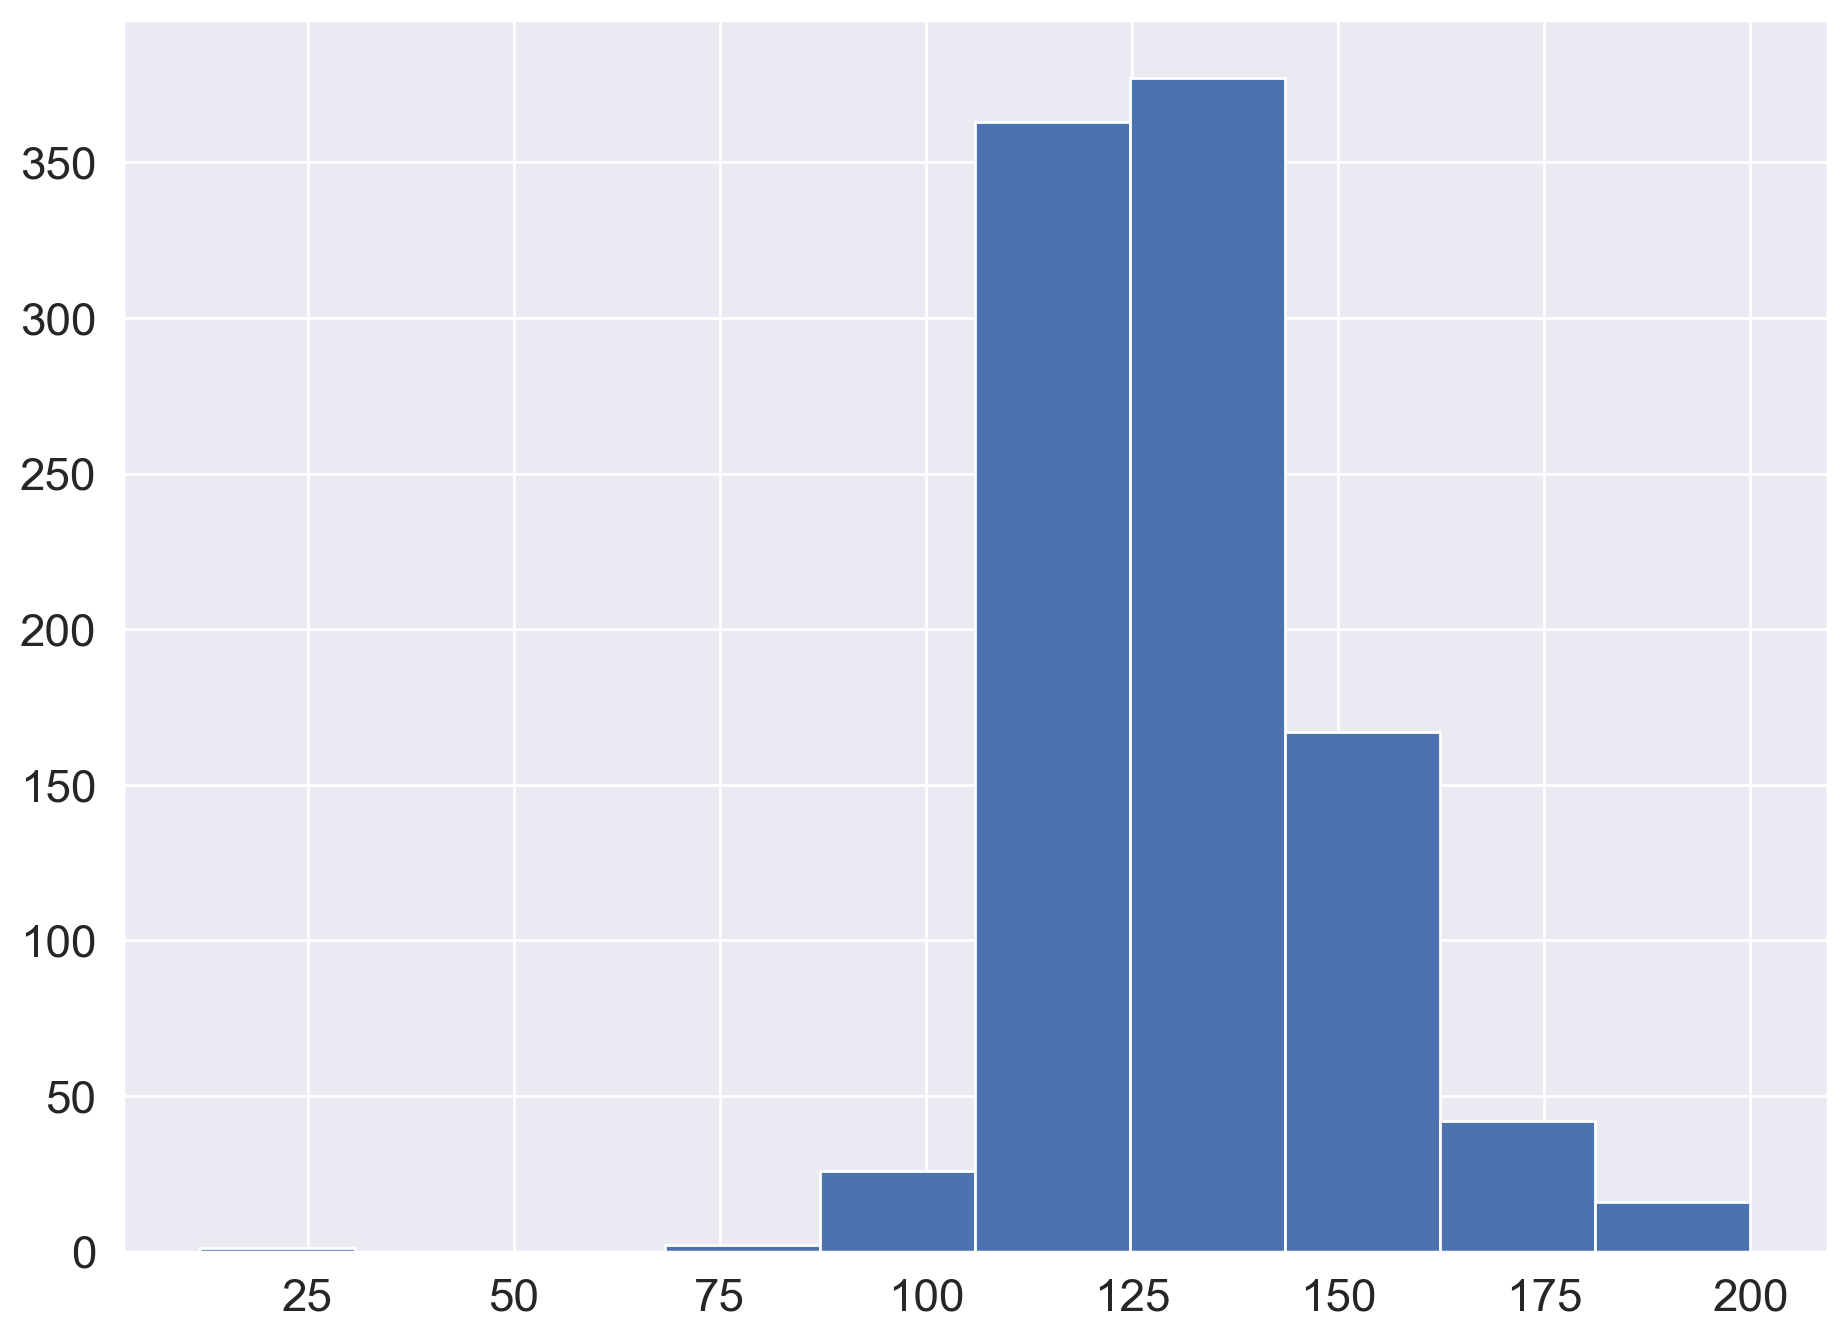

In [52]:
sub_df['ap_hi'].hist();

In [75]:
# first, let's sub-divide respondents into groups according to ap_hi: (-inf, 120), [120, 140), [140, 160), [160, 180), [180, +inf)
# what we seek is the proportion of those who have cardio diseases in each group (cholesterol x ap_hi)

def get_ap_hi_group(ap_hi):
    if ap_hi < 120:
        return 1
    elif 120 <= ap_hi < 140:
        return 2
    elif 140 <= ap_hi < 160:
        return 3
    elif 160 <= ap_hi < 180:
        return 4
    else:
        return 5


sub_df['ap_hi_group'] = sub_df['ap_hi'].apply(lambda x: get_ap_hi_group(x))

In [83]:
# let's define cardio disease rate of the sub group with the lowest ap_hi (gr. 0) \
# and the lowest cholesterol level (1) as the starting point = 1.0 = risk of cardio disease
# Then, let's compare rates of all other groups to that starting point to get a whole picture

In [84]:
sub_df_cardio_proportion = pd.DataFrame(sub_df.groupby(by=['ap_hi_group', 'cholesterol'])['cardio'].mean())\
                                        .sort_index(level=[0], ascending=False)

starting_point = sub_df_cardio_proportion['cardio'].min()
sub_df_cardio_proportion['cardio'] = sub_df_cardio_proportion['cardio'].apply(lambda x: round(x / starting_point, 1))

sub_df_cardio_proportion

cardio
ap_hi_group cholesterol        
5           3               3.9
            2               3.6
            1               3.3
4           3               3.4
            2               3.4
            1               3.5
3           3               3.3
            2               3.3
            1               3.3
2           3               3.0
            2               2.3
            1               1.5
1           3               2.3
            2               1.6
            1               1.0

In [85]:
sub_df_heatmap = np.array(sub_df_cardio_proportion).reshape([5, 3])
sub_df_heatmap

array([[3.9, 3.6, 3.3],
       [3.4, 3.4, 3.5],
       [3.3, 3.3, 3.3],
       [3. , 2.3, 1.5],
       [2.3, 1.6, 1. ]])

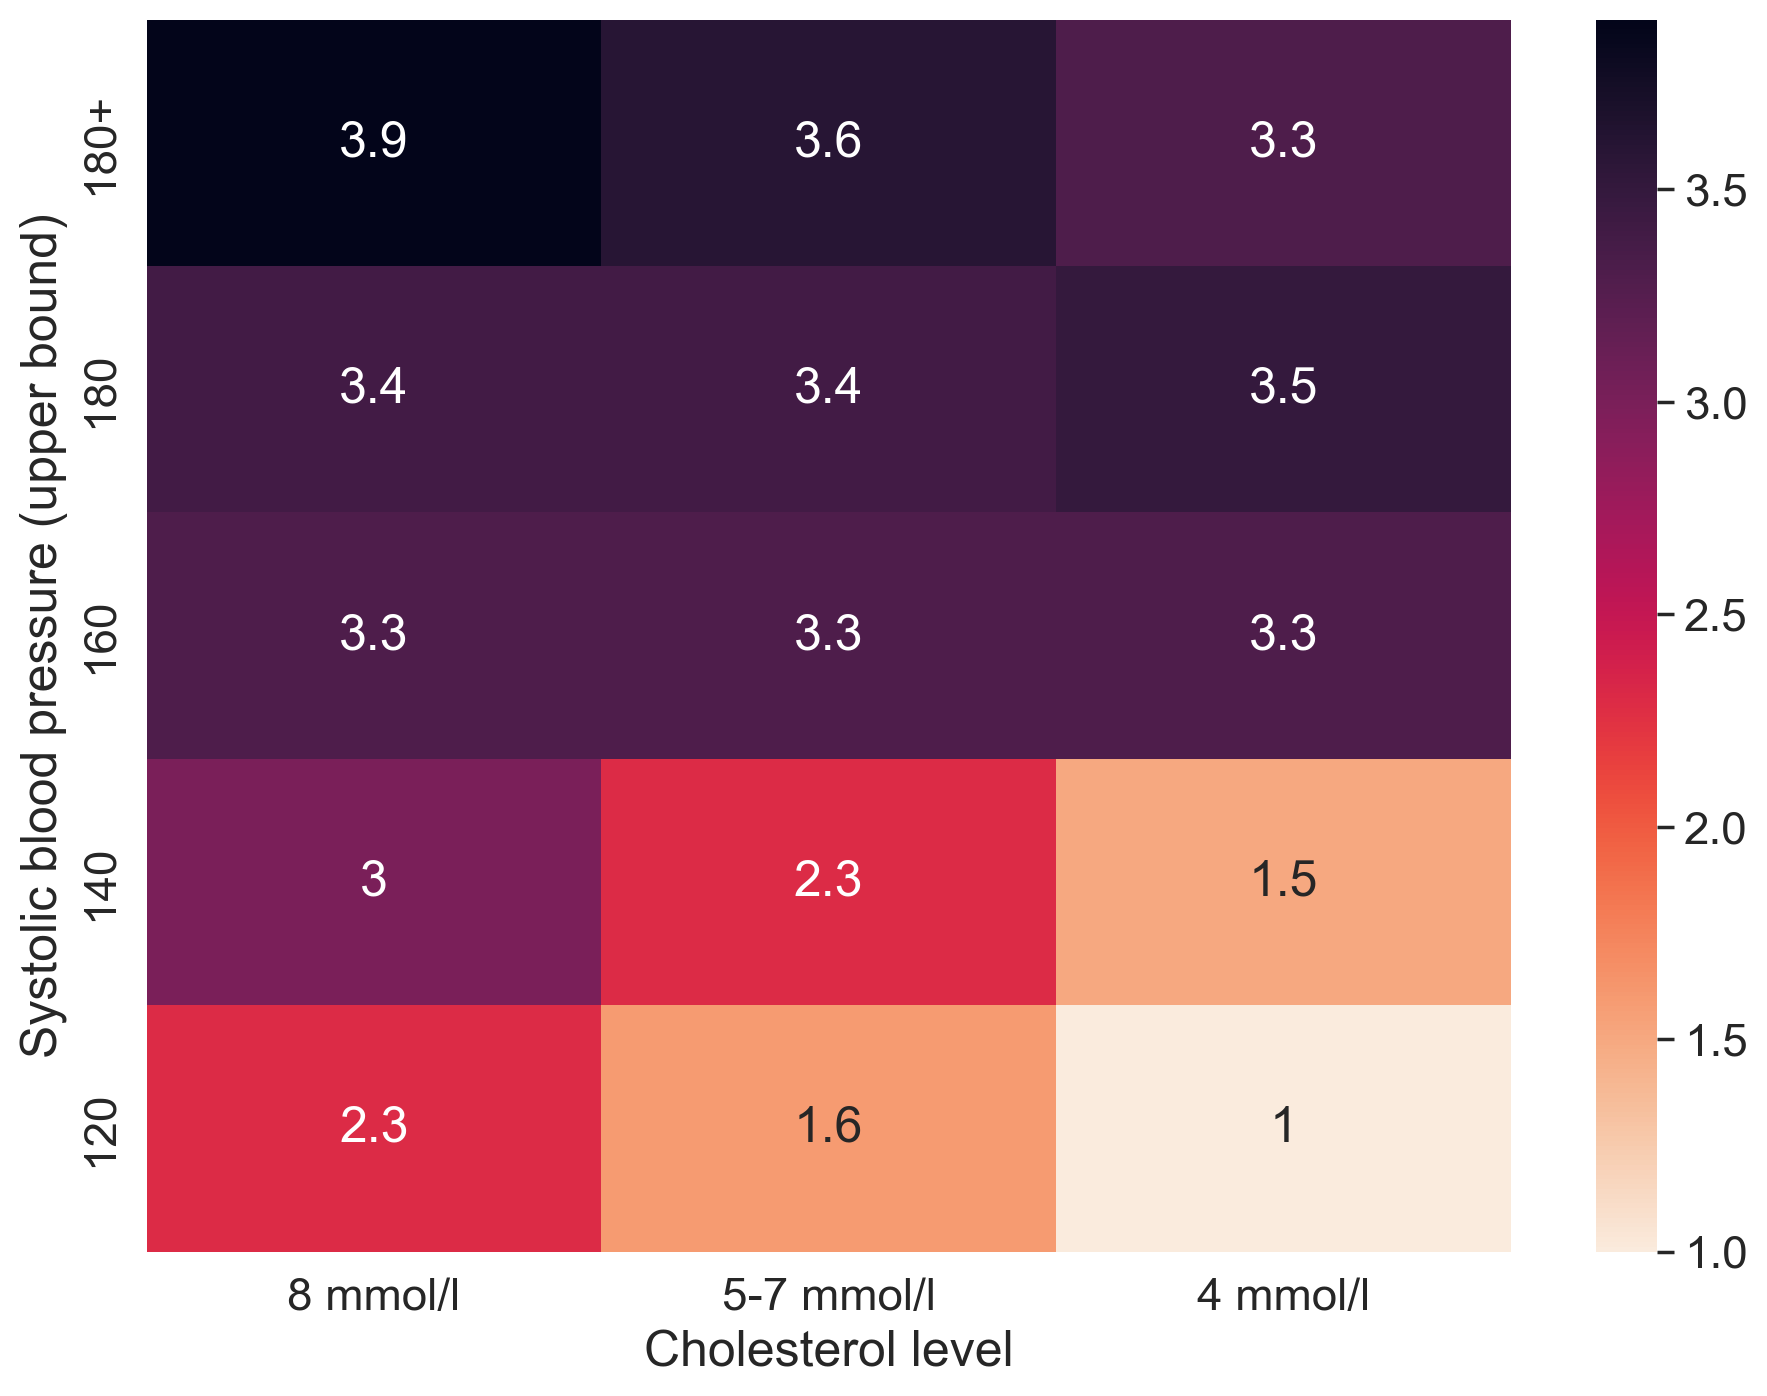

In [104]:
sub_df_hm = sns.heatmap(sub_df_heatmap,
                        annot=True,
                        cmap="rocket_r",
                        xticklabels=['8 mmol/l', '5-7 mmol/l', '4 mmol/l'],
                        yticklabels=list(reversed([120, 140, 160, 180, '180+'])))
sub_df_hm.set(xlabel='Cholesterol level', ylabel='Systolic blood pressure (upper bound)');

**Question 1.5. (2 points). Calculate fractions of ill people (with CVD) in the two groups of people described in the task. What's the ratio of these two fractions?**

1. 1
2. 2
3. 3
4. 4

## 1.3. Analyzing BMI
### Task:

Create a new feature – BMI ([Body Mass Index](https://en.wikipedia.org/wiki/Body_mass_index)). To do this, divide weight in kilograms by the square of the height in meters. Normal BMI values are said to be from 18.5 to 25.

In [7]:
df['bmi'] = df['weight'] / (df['height'] / 100)**2

In [8]:
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi
0,0,50.0,2,168,62.0,110,80,1,1,0,0,1,0,21.967120
1,1,55.0,1,156,85.0,140,90,3,1,0,0,1,1,34.927679
2,2,52.0,1,165,64.0,130,70,3,1,0,0,0,1,23.507805
3,3,48.0,2,169,82.0,150,100,1,1,0,0,1,1,28.710479
4,4,48.0,1,156,56.0,100,60,1,1,0,0,0,0,23.011177


**Question 1.6. (2 points). Choose the correct statements:**

1. Median BMI in the sample is within boundaries of normal values.
2. Women's BMI is on average higher then men's.
3. Healthy people have higher median BMI than ill people.
4. In the segment of healthy and non-drinking men BMI is closer to the norm than in the segment of healthy and non-drinking women

In [10]:
# 1
df['bmi'].median()  # no, it's slightly higher

26.374068120774975

In [11]:
# 2
df.groupby(by='gender')['bmi'].mean()  # true, women's bmi is higher than men's

gender
1    27.987583
2    26.754442
Name: bmi, dtype: float64

In [12]:
# 3
df.groupby(by='cardio')['bmi'].median()  # no, healthy people have lower bmi than ill

cardio
0    25.476660
1    27.471384
Name: bmi, dtype: float64

In [17]:
# 4
h_nd_men = df[(df['gender'] == 2) & (df['alco'] == 0) & (df['cardio'] == 0)]
h_nd_women = df[(df['gender'] == 1) & (df['alco'] == 0) & (df['cardio'] == 0)]

h_nd_men['bmi'].median(), h_nd_women['bmi'].median()  # true

(25.102391333069097, 25.654372397382513)

## 1.4. Cleaning data

### Task:
We can see that the data is not perfect. It contains "dirt" and inaccuracies. We'll see this better as we visualize the data.

Filter out the following patient segments (we consider these as erroneous data)

- diastolic pressure is higher than systolic
- height is strictly less than 2.5 percentile (Use `pd.Series.quantile` to compute this value. If you are not familiar with the function, please read the docs.)
- height is strictly more than 97.5 percentile
- weight is strictly less than 2.5 percentile
- weight is strictly more than 97.5 percentile

This is not everything that we can do to clean this data, but this is sufficient for now.

In [30]:
lo_height = df['height'].quantile(0.025)
hi_height = df['height'].quantile(0.975)
lo_height, hi_height

(150.0, 180.0)

In [31]:
lo_weight = df['weight'].quantile(0.025)
hi_weight = df['weight'].quantile(0.975)
lo_weight, hi_weight

(51.0, 108.0)

In [32]:
new_df = df.drop(df[
                    (df['ap_hi'] < df['ap_lo'])
                    | (df['height'] < lo_height)
                    | (df['height'] > hi_height)
                    | (df['weight'] < lo_weight)
                    | (df['weight'] > hi_weight)
                 ].index)

**Question 1.7. (2 points). What percent of the original data (rounded) did we filter out in the previous step?**

1. 8
2. 9
3. 10
4. 11

In [34]:
(len(df) - len(new_df)) / len(df)  # ~10%

0.0963

## Part 2. Visual data analysis <a class="tocSkip">

## 2.1. Correlation matrix visualization

To understand the features better, you can create a matrix of the correlation coefficients between the features. Use the filtered dataset from now on.

### Task:

Plot a correlation matrix using [`heatmap()`](http://seaborn.pydata.org/generated/seaborn.heatmap.html). You can create the matrix using the standard `pandas` tools with the default parameters.

In [35]:
new_df.corr()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi
id,1.000000,0.002170,0.003730,0.000326,0.000149,0.003492,0.000484,0.005581,0.002242,-0.002732,-0.000708,0.005891,0.003900,-0.000025
age,0.002170,1.000000,-0.018505,-0.076963,0.070023,0.018722,0.153500,0.154612,0.097496,-0.044482,-0.027154,-0.011317,0.239824,0.110164
gender,0.003730,-0.018505,1.000000,0.506447,0.130193,0.005063,0.059743,-0.038817,-0.023243,0.337855,0.168887,0.007791,0.002349,-0.135712
height,0.000326,-0.076963,0.506447,1.000000,0.251503,0.004586,0.017922,-0.065980,-0.028364,0.187830,0.089785,-0.005661,-0.024102,-0.266305
weight,0.000149,0.070023,0.130193,0.251503,1.000000,0.027030,0.227922,0.137705,0.094133,0.056533,0.059917,-0.014430,0.170042,0.862657
ap_hi,0.003492,0.018722,0.005063,0.004586,0.027030,1.000000,0.072803,0.021499,0.010226,-0.001928,0.000769,-0.000222,0.050556,0.024925
ap_lo,0.000484,0.153500,0.059743,0.017922,0.227922,0.072803,1.000000,0.154348,0.067048,0.023275,0.033042,0.001569,0.327181,0.216786
cholesterol,0.005581,0.154612,-0.038817,-0.065980,0.137705,0.021499,0.154348,1.000000,0.451388,0.005696,0.031050,0.007381,0.219090,0.170905
gluc,0.002242,0.097496,-0.023243,-0.028364,0.094133,0.010226,0.067048,0.451388,1.000000,-0.010225,0.005805,-0.007709,0.087621,0.108124
smoke,-0.002732,-0.044482,0.337855,0.187830,0.056533,-0.001928,0.023275,0.005696,-0.010225,1.000000,0.341200,0.026940,-0.020345,-0.041652


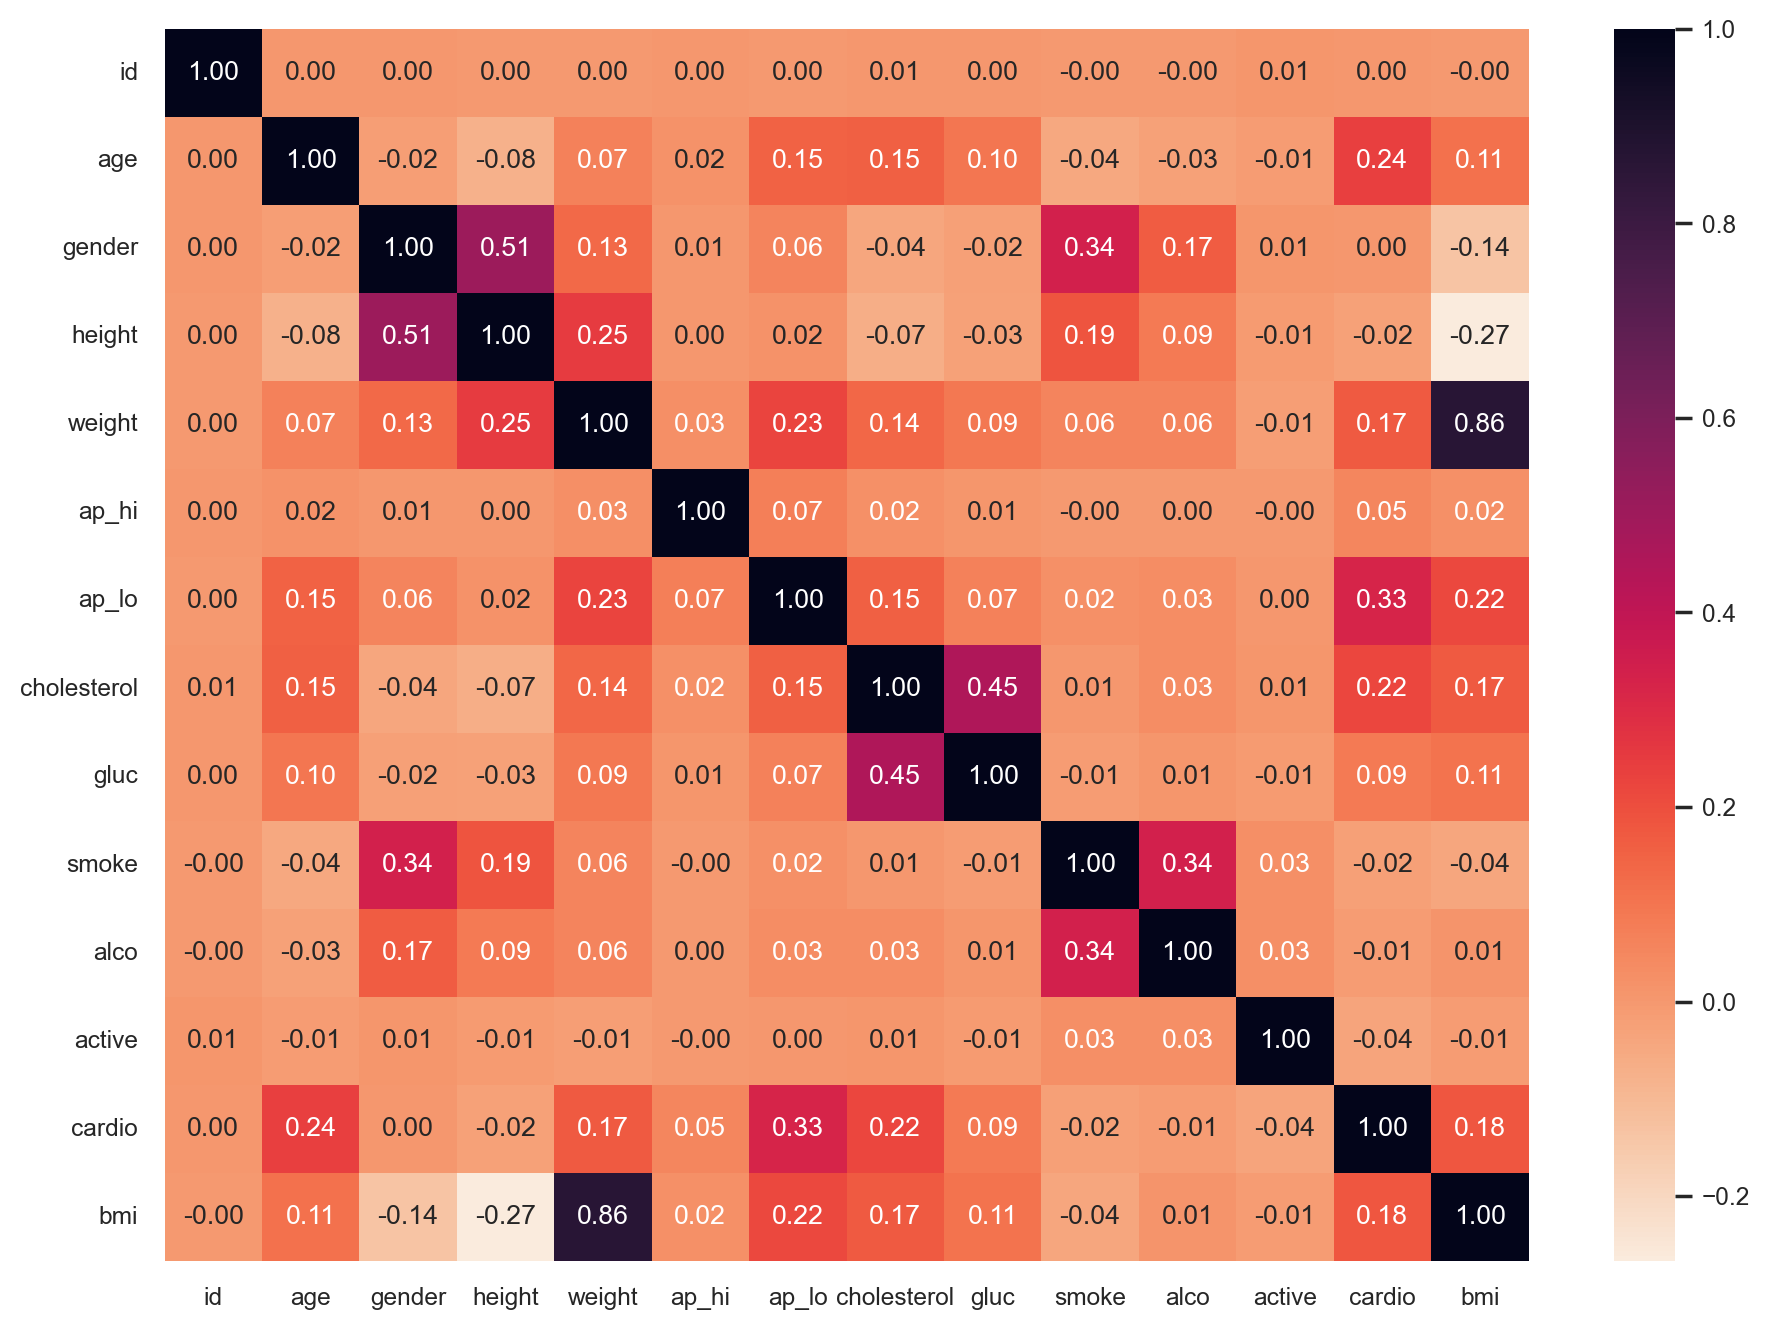

In [41]:
sns.set(font_scale=0.8)
sns.heatmap(new_df.corr(),
            annot=True,
            fmt='.2f',
            cmap="rocket_r",);

**Question 2.1. (1 point).** Which pair of features has the strongest Pearson's correlation with the *gender* feature?

1. Cardio, Cholesterol
2. Height, Smoke
3. Smoke, Alco
4. Height, Weight

In [ ]:
# 2 height, smoke

## 2.2. Height distribution of men and women

From our exploration of the unique values earlier, we know that the gender is encoded by the values *1* and *2*. Although you do not know the mapping of these values to gender, you can figure that out graphically by looking at the mean values of height and weight for each value of the *gender* feature.

### Task:

Create a violin plot for the height and gender using [`violinplot()`](https://seaborn.pydata.org/generated/seaborn.violinplot.html). Use the parameters:
- `hue` to split by gender;
- `scale` to evaluate the number of records for each gender.

In order for the plot to render correctly, you need to convert your `DataFrame` to *long* format using the `melt()` function from `pandas`. Here is [an example](https://stackoverflow.com/a/41575149/3338479) of this for your reference.

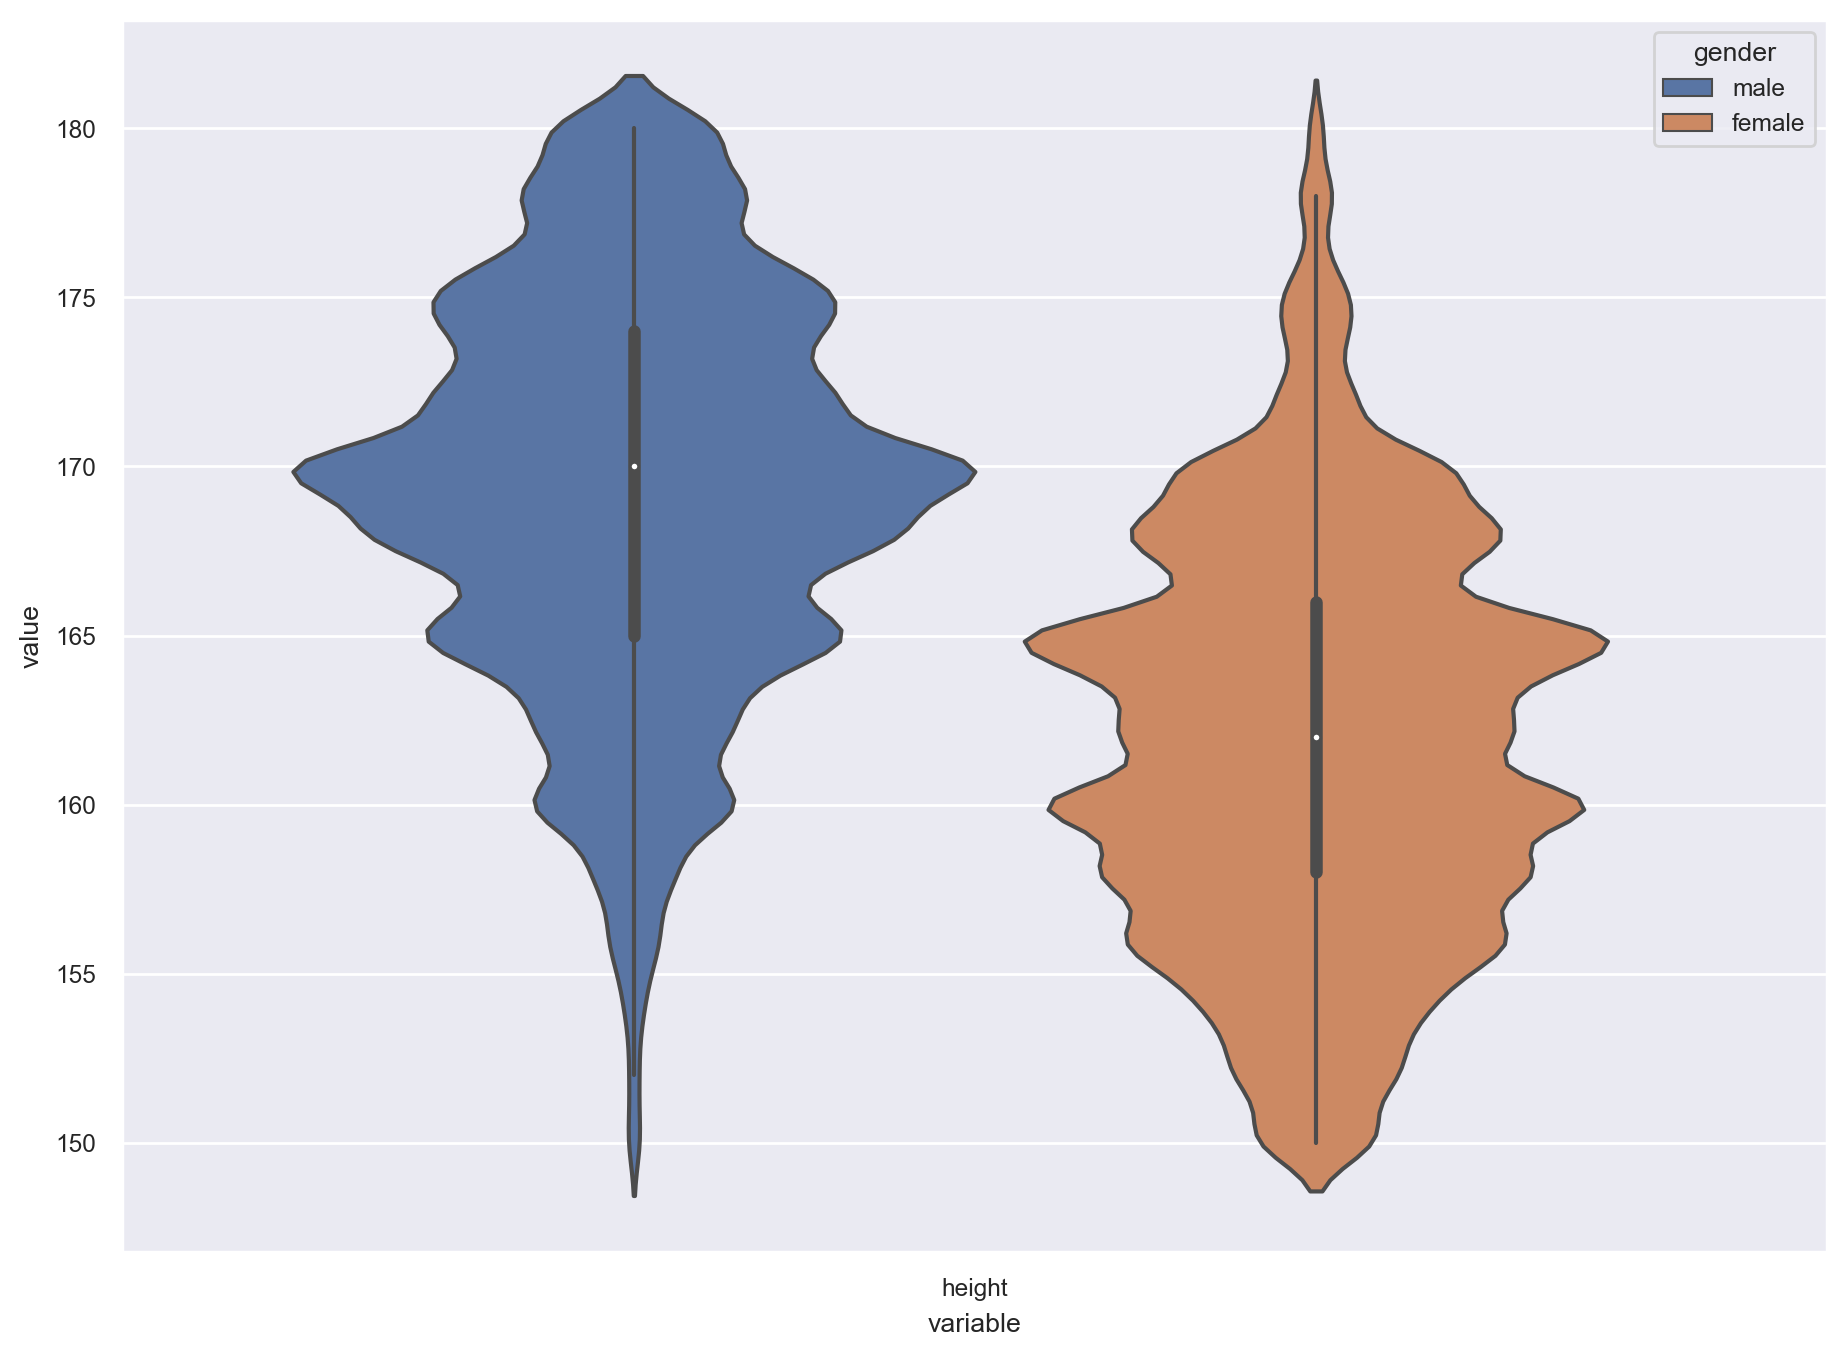

In [50]:
new_df_long = pd.melt(frame=new_df, value_vars='height', id_vars='gender')
new_df_long['gender'] = new_df_long['gender'].map({1: 'female', 2: 'male'})
sns.violinplot(x='variable', y='value', hue='gender', data=new_df_long);
# seems like the median almost remained the same

## 2.3. Rank correlation

In most cases, *the Pearson coefficient of linear correlation* is more than enough to discover patterns in data.
But let's go a little further and calculate a [rank correlation](https://en.wikipedia.org/wiki/Rank_correlation). It will help us to identify such feature pairs in which the lower rank in the variational series of one feature always precedes the higher rank in the another one (and we have the opposite in the case of negative correlation).

### Task:

Calculate and plot a correlation matrix using the [Spearman's rank correlation coefficient](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient).

In [51]:
new_df.corr(method='spearman')

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi
id,1.000000,0.001478,0.003727,0.000802,0.000634,0.005825,0.001021,0.004494,0.002312,-0.002741,-0.000716,0.005914,0.003899,-0.000656
age,0.001478,1.000000,-0.015729,-0.075043,0.071877,0.223314,0.159580,0.142065,0.090762,-0.044027,-0.027226,-0.011556,0.237823,0.110231
gender,0.003727,-0.015729,1.000000,0.510813,0.141272,0.059131,0.059237,-0.038729,-0.021881,0.337855,0.168887,0.007791,0.002349,-0.106183
height,0.000802,-0.075043,0.510813,1.000000,0.262531,0.005737,0.015586,-0.066984,-0.031342,0.187564,0.088116,-0.004826,-0.023685,-0.230465
weight,0.000634,0.071877,0.141272,0.262531,1.000000,0.257434,0.231913,0.133133,0.100072,0.060794,0.060163,-0.011813,0.168049,0.858386
ap_hi,0.005825,0.223314,0.059131,0.005737,0.257434,1.000000,0.736208,0.204520,0.097666,0.024877,0.030566,-0.000420,0.447185,0.256771
ap_lo,0.001021,0.159580,0.059237,0.015586,0.231913,0.736208,1.000000,0.162013,0.074264,0.022317,0.033251,0.004430,0.350219,0.226674
cholesterol,0.004494,0.142065,-0.038729,-0.066984,0.133133,0.204520,0.162013,1.000000,0.407645,0.010230,0.036269,0.004398,0.212815,0.167760
gluc,0.002312,0.090762,-0.021881,-0.031342,0.100072,0.097666,0.074264,0.407645,1.000000,-0.005629,0.012451,-0.009680,0.089192,0.117118
smoke,-0.002741,-0.044027,0.337855,0.187564,0.060794,0.024877,0.022317,0.010230,-0.005629,1.000000,0.341200,0.026940,-0.020345,-0.029461


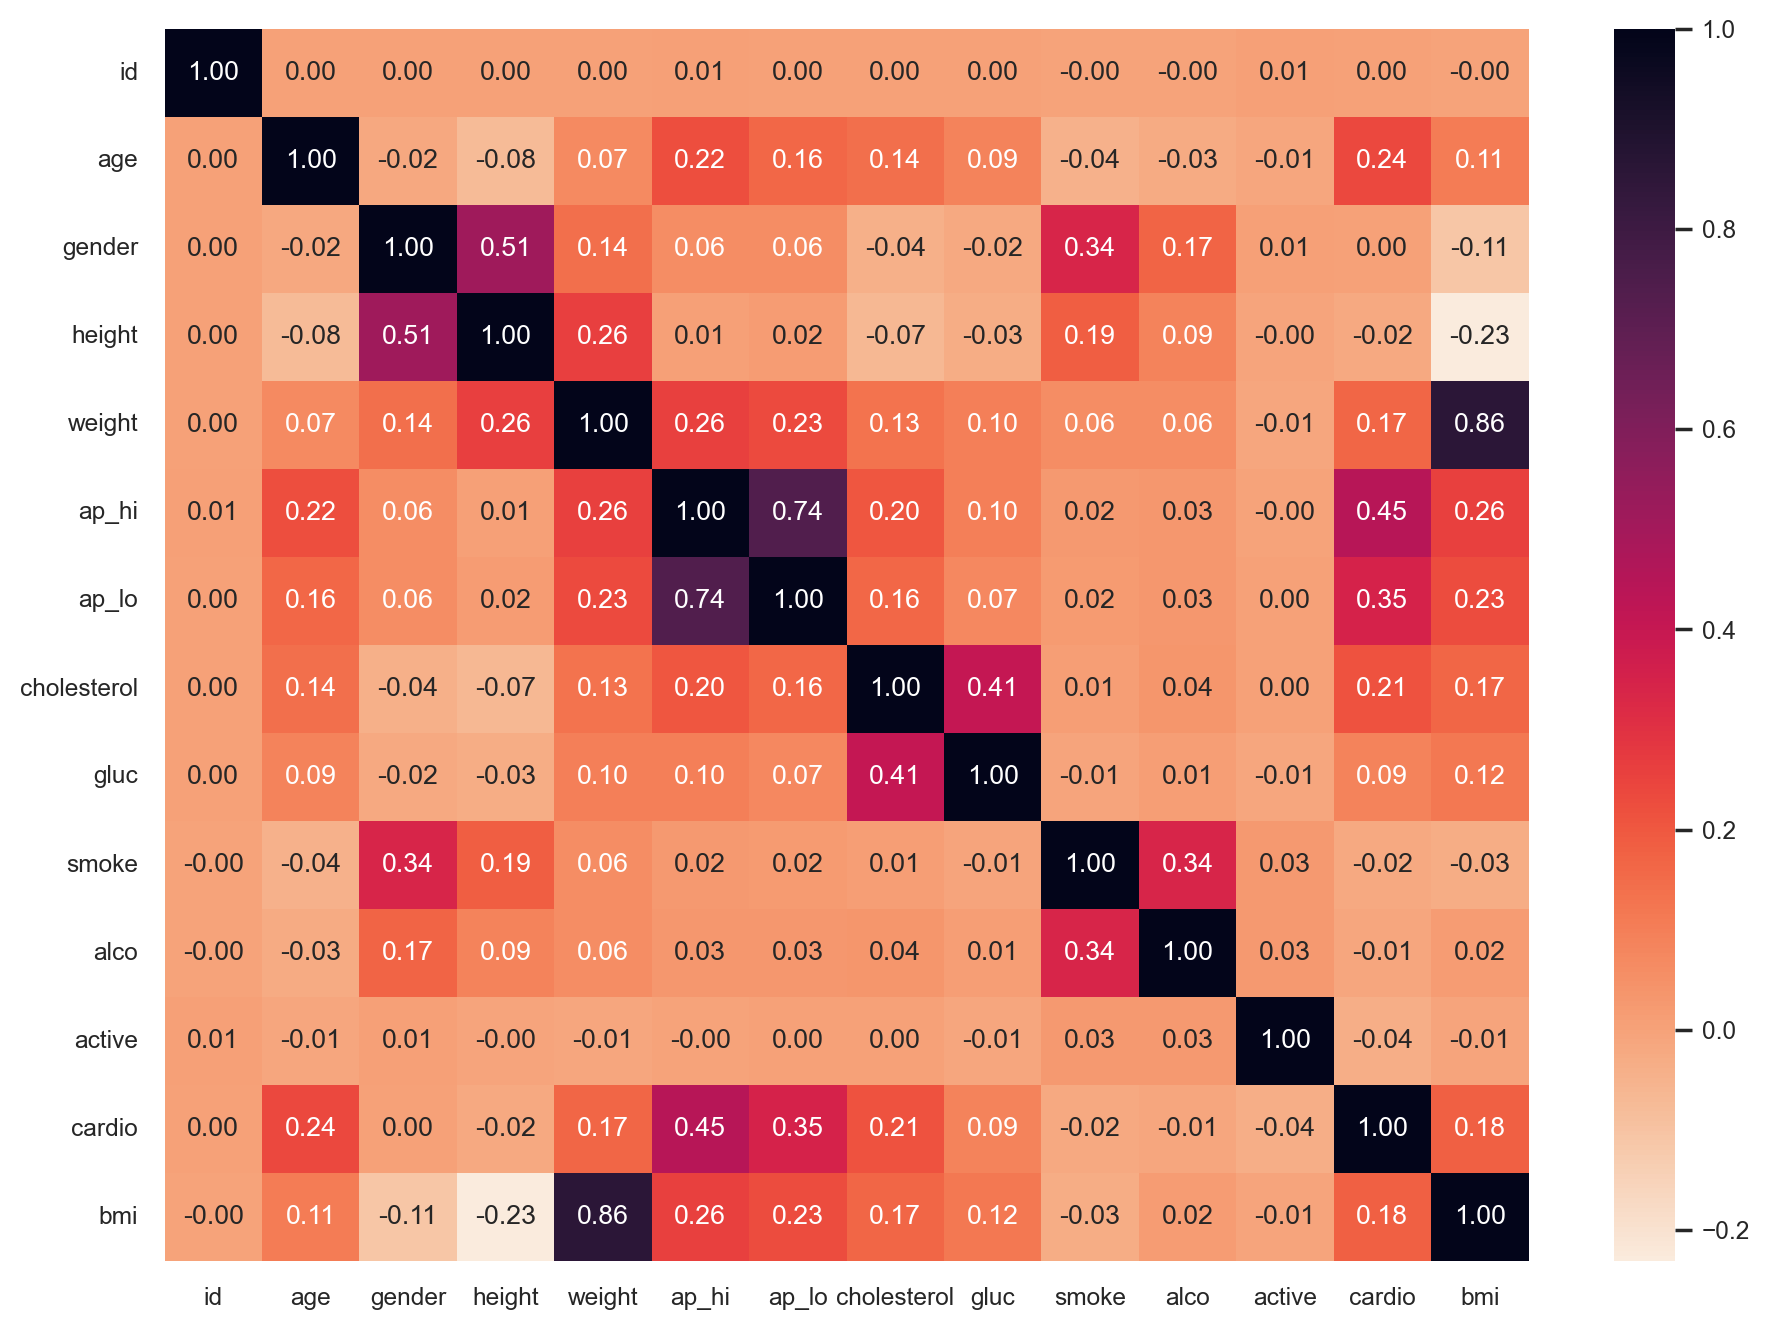

In [52]:
sns.heatmap(new_df.corr(method='spearman'),
            annot=True,
            fmt='.2f',
            cmap="rocket_r",);

**Question 2.2. (1 point).** Which pair of features has the strongest Spearman rank correlation?

1. Height, Weight
2. Age, Weight
3. Cholesterol, Gluc
4. Cardio, Cholesterol
5. Ap_hi, Ap_lo
6. Smoke, Alco

In [ ]:
# 5 ap_hi, ap_lo

**Question 2.3. (1 point).** Why do these features have strong rank correlation?

1. Inaccuracies in the data (data acquisition errors).
2. Relation is wrong, these features should not be related.
3. Nature of the data.

In [66]:
# 3 nature of the data
# Pearson's coefficient reflects linearity of correlation, while Spearman's coefficient reflects monotony of one
# Although higher ranges of values of ap_lo usually correspond to higher ranges of values of ap_hi, they do not correlate linearly

## 2.4. Age

Previously, we calculated the age of the respondents in years at the moment of examination.

### Task:

Create a *count plot* using [`countplot()`](http://seaborn.pydata.org/generated/seaborn.countplot.html) with the age on the *X* axis and the number of people on the *Y* axis. Your resulting plot should have two columns for each age, corresponding to the number of people for each *cardio* class of that age.

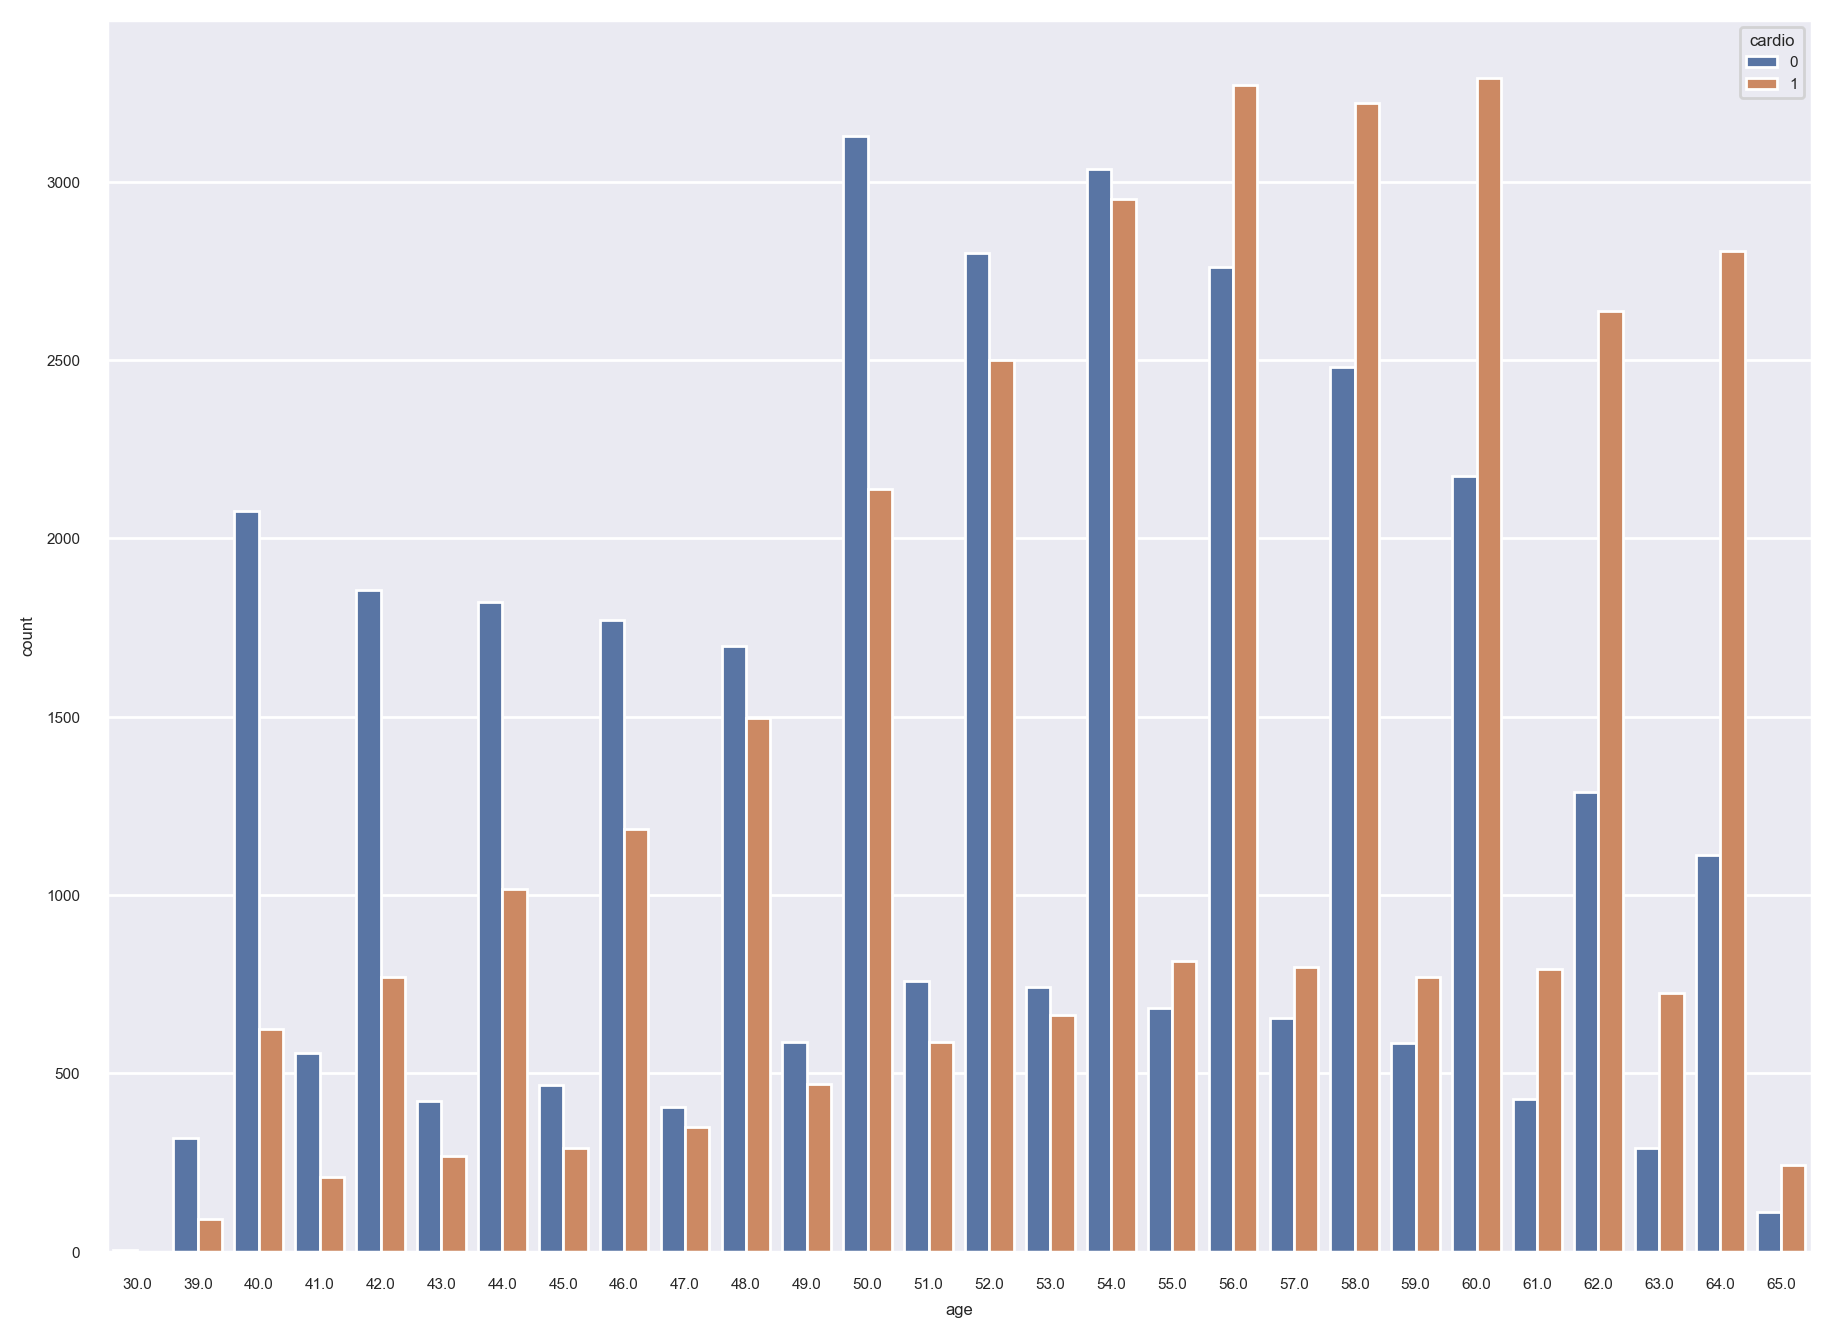

In [10]:
sns.set(font_scale=0.5)
sns.countplot(data=df, x='age', hue='cardio');

**Question 2.4. (1 point).** What is the smallest age at which the number of people with CVD outnumbers the number of people without CVD?

1. 44
2. 55
3. 64
4. 70

In [ ]:
# 55